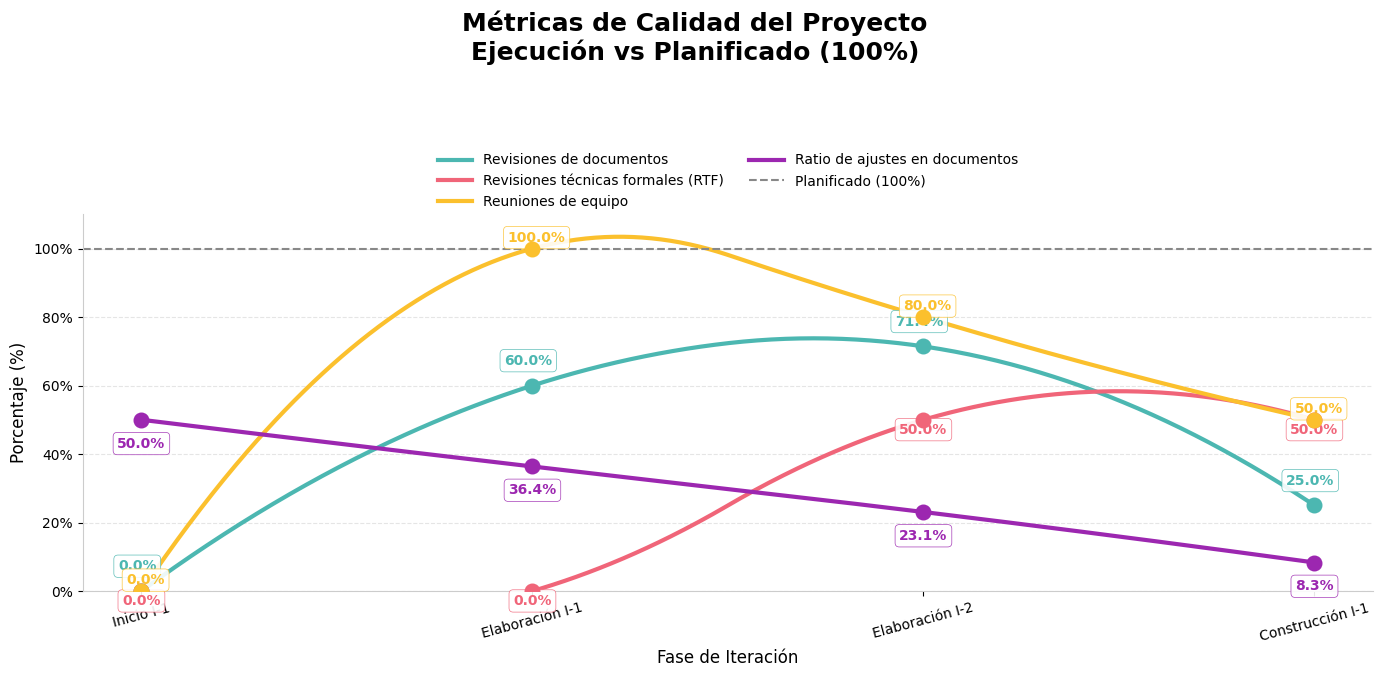

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import matplotlib.ticker as mtick

# ================== 1. DATOS ==================
# Aseguramos que todos los DataFrames tengan las 4 fases para la alineación correcta
df_ajustes = pd.DataFrame({
    'Etapa': ['Inicio I-1', 'Elaboración I-1', 'Elaboración I-2', 'Construcción I-1'],
    'Trabajo total': [8, 11, 13, 6],
    'ajustes en documento': [4, 4, 3, 0.5]
})

df_reuniones = pd.DataFrame({
    'Etapa': ['Inicio I-1', 'Elaboración I-1', 'Elaboración I-2', 'Construcción I-1'],
    'Previstas': [0, 3, 5, 2],
    'Realizadas': [0, 3, 4, 1]
})

df_rtf = pd.DataFrame({
    'Etiqueta': ['Inicio I-1', 'Elaboración I-1', 'Elaboración I-2', 'Construcción I-1'],
    'Previstas': [0, 0, 2, 2],
    'Realizadas': [0, 0, 1, 1]
}).rename(columns={'Etiqueta': 'Etapa'})

df_revisiones = pd.DataFrame({
    'Etapa': ['Inicio I-1', 'Elaboración I-1', 'Elaboración I-2', 'Construcción I-1'],
    'Previstas': [0, 5, 7, 4],
    'Realizadas': [0, 3, 5, 1]
})

# ================== 2. FUNCIONES Y PROCESAMIENTO ==================
def calculate_percentage(df, previstas_col, realizadas_col, metric_name):
    df[previstas_col] = pd.to_numeric(df[previstas_col], errors='coerce').fillna(0)
    df[realizadas_col] = pd.to_numeric(df[realizadas_col], errors='coerce').fillna(0)
    df['Porcentaje'] = np.where(
        df[previstas_col] == 0,
        np.where(df[realizadas_col] == 0, 0, np.nan),
        (df[realizadas_col] / df[previstas_col]) * 100
    )
    return df[['Etapa', 'Porcentaje']].rename(columns={'Porcentaje': metric_name})

df_ajustes_proc = calculate_percentage(df_ajustes, 'Trabajo total', 'ajustes en documento', 'Ratio de ajustes en documentos')
df_reuniones_proc = calculate_percentage(df_reuniones, 'Previstas', 'Realizadas', 'Reuniones de equipo')
df_rtf_proc = calculate_percentage(df_rtf, 'Previstas', 'Realizadas', 'Revisiones técnicas formales (RTF)')
df_revisiones_proc = calculate_percentage(df_revisiones, 'Previstas', 'Realizadas', 'Revisiones de documentos')

df_merged = df_ajustes_proc.merge(df_reuniones_proc, on='Etapa', how='outer') \
                           .merge(df_rtf_proc, on='Etapa', how='outer') \
                           .merge(df_revisiones_proc, on='Etapa', how='outer')

# ================== 3. CONFIGURAR DATOS PARA PLOT ==================
orden_fases = ['Inicio I-1', 'Elaboración I-1', 'Elaboración I-2', 'Construcción I-1']
df_merged['Etapa'] = pd.Categorical(df_merged['Etapa'], categories=orden_fases, ordered=True)
df_merged = df_merged.sort_values('Etapa')
x = np.arange(len(orden_fases))

def align_data(metric_name):
    return [df_merged.loc[df_merged['Etapa'] == fase, metric_name].values[0]
             if fase in df_merged['Etapa'].values else np.nan for fase in orden_fases]

# Offsets y Colores (Ajustados para separación y estilo)
metricas = [
    {'name': 'Revisiones de documentos', 'data': align_data('Revisiones de documentos'), 'color': '#4CB7B1', 'offset_y': 15, 'offset_x': -3},
    {'name': 'Revisiones técnicas formales (RTF)', 'data': align_data('Revisiones técnicas formales (RTF)'), 'color': '#F06579', 'offset_y': -10, 'offset_x': 0},
    {'name': 'Reuniones de equipo', 'data': align_data('Reuniones de equipo'), 'color': '#FBC02D', 'offset_y': 5, 'offset_x': 3},
    {'name': 'Ratio de ajustes en documentos', 'data': align_data('Ratio de ajustes en documentos'), 'color': '#9C27B0', 'offset_y': -20, 'offset_x': 0}
]

# ================== 4. GRÁFICO FINAL ==================
fig, ax = plt.subplots(figsize=(14, 7))

# Estilo General
fig.patch.set_facecolor('white')
ax.grid(axis='y', linestyle='--', alpha=0.5, color='#CCCCCC')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['bottom'].set_color('#CCCCCC')

x_smooth = np.linspace(x.min(), x.max(), 300)

for metric in metricas:
    y = np.array(metric['data'])
    mask = ~np.isnan(y)

    # Suavizado de Líneas (Ondas)
    x_valid = x[mask]
    y_valid = y[mask]

    if len(x_valid) >= 2:
        spline = make_interp_spline(x_valid, y_valid, k=2)
        X_ = np.linspace(x_valid.min(), x_valid.max(), 500)
        Y_ = spline(X_)

        ax.plot(X_, Y_, linewidth=3, color=metric['color'], label=metric['name'])

    # Marcadores
    ax.scatter(x_valid, y_valid, color=metric['color'], s=100, edgecolor=metric['color'], linewidth=1.5, zorder=5)

    # Etiquetas (Corregidas y mejoradas)
    for xi, yi in zip(x_valid, y_valid):
        ax.annotate(f'{yi:.1f}%', xy=(xi, yi),
                    xytext=(metric['offset_x'], metric['offset_y']),
                    textcoords='offset points', ha='center',
                    fontsize=10, fontweight='bold', color=metric['color'],
                    bbox=dict(facecolor='white', alpha=0.9, edgecolor=metric['color'], boxstyle='round,pad=0.3', linewidth=0.5)
                    )

# Línea de referencia (Planificado 100%)
plt.axhline(100, color='#888888', linestyle='--', linewidth=1.5, label='Planificado (100%)')

# Títulos y Estilo Final
fig.suptitle('Métricas de Calidad del Proyecto\nEjecución vs Planificado (100%)',
             fontsize=18, fontweight='bold', y=0.96)

ax.set_ylabel('Porcentaje (%)', fontsize=12)
ax.set_xlabel('Fase de Iteración', fontsize=12)
ax.set_ylim(0, 110)
ax.set_xticks(x)
ax.set_xticklabels(orden_fases, rotation=15)

# Formato del Eje Y
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100.0))

# Leyenda (Superior, dos columnas)
ax.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, 0.98),
    ncol=2,
    fontsize=10,
    frameon=False,
    columnspacing=1.8,
    handlelength=2.5
)

plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show() # <--- ESTO MUESTRA EL GRÁFICO EN COLAB